In [1]:
%matplotlib inline


Audio I/O
=========

This tutorial shows how to use TorchAudio's basic I/O API to load audio files
into PyTorch's Tensor object, and save Tensor objects to audio files.


In [2]:
!pip3 install torch torchvision torchaudio

/usr/local/lib/python3.8/dist-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/local/lib/python3.8/dist-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 75.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 97.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 5.2 MB/s eta 0:00:0000:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  NOTE: The current PATH contains path(s) starting with `~`, which may not be expanded by all applications.
You should consider upg

In [3]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

1.12.0+cu102
0.12.0+cu102


Preparation
-----------

First, we import the modules and download the audio assets we use in this tutorial.

<div class="alert alert-info"><h4>Note</h4><p>When running this tutorial in Google Colab, install the required packages
   with the following:

   .. code::

      !pip install boto3</p></div>



Python용 AWS SDK인 boto3를 사용하여 AWS를 빠르게 시작하십시오. Boto3를 사용하면 Python 애플리케이션, 라이브러리 또는 스크립트를 Amazon S3, Amazon EC2, Amazon DynamoDB 등 AWS 서비스와 쉽게 통합할 수 있습니다.

In [4]:
import io
import os
import tarfile
import tempfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
from torchaudio.utils import download_asset

SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_WAV_8000 = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")

  0%|          | 0.00/7.99k [00:00<?, ?B/s]

  0%|          | 0.00/106k [00:00<?, ?B/s]

  0%|          | 0.00/53.2k [00:00<?, ?B/s]

Querying audio metadata
-----------------------

Function :py:func:`torchaudio.info` fetches audio metadata.
You can provide a path-like object or file-like object.




In [5]:
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


Where

-  ``sample_rate`` is the sampling rate of the audio
-  ``num_channels`` is the number of channels
-  ``num_frames`` is the number of frames per channel
-  ``bits_per_sample`` is bit depth
-  ``encoding`` is the sample coding format

``encoding`` can take on one of the following values:\
PCM: 아날로그 신호의 디지털 표현
-  ``"PCM_S"``: Signed integer linear PCM
-  ``"PCM_U"``: Unsigned integer linear PCM
-  ``"PCM_F"``: Floating point linear PCM
-  ``"FLAC"``: Flac, `Free Lossless Audio
   Codec <https://xiph.org/flac/>`__
-  ``"ULAW"``: Mu-law,
   [`wikipedia <https://en.wikipedia.org/wiki/%CE%9C-law_algorithm>`__]
-  ``"ALAW"``: A-law
   [`wikipedia <https://en.wikipedia.org/wiki/A-law_algorithm>`__]
-  ``"MP3"`` : MP3, MPEG-1 Audio Layer III
-  ``"VORBIS"``: OGG Vorbis [`xiph.org <https://xiph.org/vorbis/>`__]
-  ``"AMR_NB"``: Adaptive Multi-Rate
   [`wikipedia <https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_audio_codec>`__]
-  ``"AMR_WB"``: Adaptive Multi-Rate Wideband
   [`wikipedia <https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_Wideband>`__]
-  ``"OPUS"``: Opus [`opus-codec.org <https://opus-codec.org/>`__]
-  ``"GSM"``: GSM-FR
   [`wikipedia <https://en.wikipedia.org/wiki/Full_Rate>`__]
-  ``"HTK"``: Single channel 16-bit PCM
-  ``"UNKNOWN"`` None of above




**Note**

-  ``bits_per_sample`` can be ``0`` for formats with compression and/or
   variable bit rate (such as MP3).
-  ``num_frames`` can be ``0`` for GSM-FR format.




In [6]:
metadata = torchaudio.info(SAMPLE_GSM)
print(metadata)

AudioMetaData(sample_rate=8000, num_frames=0, num_channels=1, bits_per_sample=0, encoding=GSM)


Querying file-like object
-------------------------

:py:func:`torchaudio.info` works on file-like objects.




In [7]:
url = "https://download.pytorch.org/torchaudio/tutorial-assets/steam-train-whistle-daniel_simon.wav"
with requests.get(url, stream=True) as response:
    metadata = torchaudio.info(response.raw)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


<div class="alert alert-info"><h4>Note</h4><p>When passing a file-like object, ``info`` does not read
   all of the underlying data; rather, it reads only a portion
   of the data from the beginning.
   Therefore, for a given audio format, it may not be able to retrieve the
   correct metadata, including the format itself. In such case, you
   can pass ``format`` argument to specify the format of the audio.
   
   파일류 객체를 전달할 때 info는 모든 기본 데이터를 읽지 않습니다. 오히려 처음부터 데이터의 일부만 읽습니다.
따라서 지정된 오디오 형식의 경우 형식 자체를 포함하여 올바른 메타데이터를 검색하지 못할 수 있습니다. 이 경우 format 인수를 전달하여 오디오 형식을 지정할 수 있습니다.</p></div>



Loading audio data
------------------

To load audio data, you can use :py:func:`torchaudio.load`.

This function accepts a path-like object or file-like object as input.

The returned value is a tuple of waveform (``Tensor``) and sample rate
(``int``).

By default, the resulting tensor object has ``dtype=torch.float32`` and
its value range is ``[-1.0, 1.0]``.

For the list of supported format, please refer to `the torchaudio
documentation <https://pytorch.org/audio>`__.




In [8]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

In [9]:
waveform, waveform.shape

(tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]]),
 torch.Size([1, 54400]))

In [10]:
sample_rate

16000

In [11]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

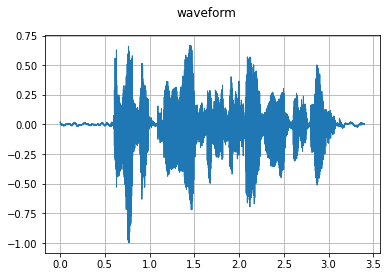

In [12]:
plot_waveform(waveform, sample_rate)

In [13]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

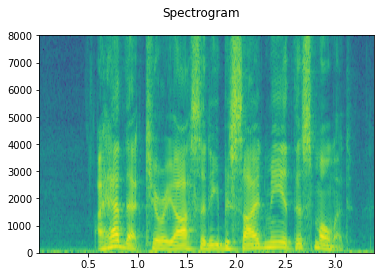

In [14]:
plot_specgram(waveform, sample_rate)

In [17]:
Audio(waveform.numpy()[0], rate=sample_rate)

Loading from file-like object
-----------------------------

The I/O functions support file-like objects.
This allows for fetching and decoding audio data from locations
within and beyond the local file system.
The following examples illustrate this.




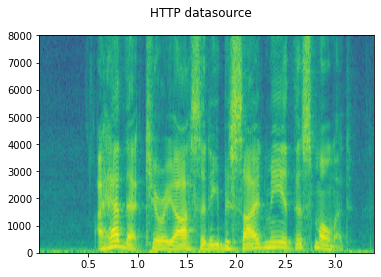

In [18]:
# Load audio data as HTTP request
url = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
with requests.get(url, stream=True) as response:
    waveform, sample_rate = torchaudio.load(response.raw)
plot_specgram(waveform, sample_rate, title="HTTP datasource")

  0%|          | 0.00/110k [00:00<?, ?B/s]

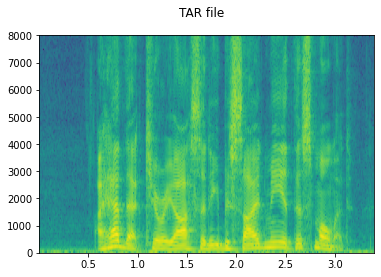

In [19]:
# Load audio from tar file
tar_path = download_asset("tutorial-assets/VOiCES_devkit.tar.gz")
tar_item = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
with tarfile.open(tar_path, mode="r") as tarfile_:
    fileobj = tarfile_.extractfile(tar_item)
    waveform, sample_rate = torchaudio.load(fileobj)
plot_specgram(waveform, sample_rate, title="TAR file")

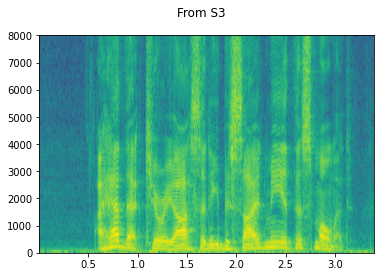

In [20]:
# Load audio from S3
bucket = "pytorch-tutorial-assets"
key = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
client = boto3.client("s3", config=Config(signature_version=UNSIGNED))
response = client.get_object(Bucket=bucket, Key=key)
waveform, sample_rate = torchaudio.load(response["Body"])
plot_specgram(waveform, sample_rate, title="From S3")

Tips on slicing
---------------

Providing ``num_frames`` and ``frame_offset`` arguments restricts
decoding to the corresponding segment of the input.\
num_frames 및 frame_offset 인수를 제공하면 입력의 해당 세그먼트로 디코딩이 제한됩니다.

The same result can be achieved using vanilla Tensor slicing,
(i.e. ``waveform[:, frame_offset:frame_offset+num_frames]``). However,
providing ``num_frames`` and ``frame_offset`` arguments is more
efficient.\
바닐라 텐서 슬라이싱을 사용하여 동일한 결과를 얻을 수 있습니다, waveform[:,frame_offset:frame_offset+num_frames]). \
그러나 num_frames 및 frame_offset 인수를 제공하는 것이 더 효율적입니다.

This is because the function will end data acquisition and decoding
once it finishes decoding the requested frames. This is advantageous
when the audio data are transferred via network as the data transfer will
stop as soon as the necessary amount of data is fetched.\
이는 요청된 프레임 디코딩이 완료되면 함수가 데이터 수집 및 디코딩을 종료하기 때문입니다. 필요한 양의 데이터를 가져오는 즉시 데이터 전송을 중지하므로 네트워크를 통해 오디오 데이터를 전송할 때 유리합니다.


The following example illustrates this.




In [21]:
# Illustration of two different decoding methods.
# The first one will fetch all the data and decode them, while
# the second one will stop fetching data once it completes decoding.
# The resulting waveforms are identical.

frame_offset, num_frames = 16000, 16000  # Fetch and decode the 1 - 2 seconds

url = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
print("Fetching all the data...")
with requests.get(url, stream=True) as response:
    waveform1, sample_rate1 = torchaudio.load(response.raw)
    waveform1 = waveform1[:, frame_offset : frame_offset + num_frames]
    print(f" - Fetched {response.raw.tell()} bytes")

print("Fetching until the requested frames are available...")
with requests.get(url, stream=True) as response:
    waveform2, sample_rate2 = torchaudio.load(response.raw, frame_offset=frame_offset, num_frames=num_frames)
    print(f" - Fetched {response.raw.tell()} bytes")

print("Checking the resulting waveform ... ", end="")
assert (waveform1 == waveform2).all()
print("matched!")

Fetching all the data...
 - Fetched 108844 bytes
Fetching until the requested frames are available...
 - Fetched 65580 bytes
Checking the resulting waveform ... matched!


Saving audio to file
--------------------

To save audio data in formats interpretable by common applications,
you can use :py:func:`torchaudio.save`.

This function accepts a path-like object or file-like object.

When passing a file-like object, you also need to provide argument ``format``
so that the function knows which format it should use. In the
case of a path-like object, the function will infer the format from
the extension. If you are saving to a file without an extension, you need
to provide argument ``format``.

When saving WAV-formatted data, the default encoding for ``float32`` Tensor
is 32-bit floating-point PCM. You can provide arguments ``encoding`` and
``bits_per_sample`` to change this behavior. For example, to save data
in 16-bit signed integer PCM, you can do the following.

<div class="alert alert-info"><h4>Note</h4><p></p></div>

Saving data in encodings with a lower bit depth reduces the
resulting file size but also precision.\
더 낮은 비트 심도로 인코딩으로 데이터를 저장하면 결과 파일 크기는 줄어들지만 정밀도도 줄어듭니다.




In [22]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

In [23]:
def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")
    print()

Save without any encoding option.
The function will pick up the encoding which
the provided data fit\
인코딩 옵션 없이 저장합니다. 함수는 제공된 데이터에 맞는 인코딩을 선택합니다.



In [24]:
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_default.wav"
    torchaudio.save(path, waveform, sample_rate)
    inspect_file(path)

----------
Source: /tmp/tmpgpmspreg/save_example_default.wav
----------
 - File size: 217658 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=32, encoding=PCM_F)



Save as 16-bit signed integer Linear PCM
The resulting file occupies half the storage but loses precision



In [25]:
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_PCM_S16.wav"
    torchaudio.save(path, waveform, sample_rate, encoding="PCM_S", bits_per_sample=16)
    inspect_file(path)

----------
Source: /tmp/tmpoe6mafig/save_example_PCM_S16.wav
----------
 - File size: 108844 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)



:py:func:`torchaudio.save` can also handle other formats.
To name a few:\

py:func:torchaudio.save는 다른 형식도 처리할 수 있습니다. 몇 가지 예를 들면 다음과 같습니다.



In [26]:
formats = [
    "flac",
    "vorbis",
    "sph",
    "amb",
    "amr-nb",
    "gsm",
]

In [27]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_8000)
with tempfile.TemporaryDirectory() as tempdir: # 임시 디렉토리를 생성
    for format in formats:
        path = f"{tempdir}/save_example.{format}"
        torchaudio.save(path, waveform, sample_rate, format=format)
        inspect_file(path)

----------
Source: /tmp/tmpnb6vituf/save_example.flac
----------
 - File size: 37141 bytes
 - AudioMetaData(sample_rate=8000, num_frames=27200, num_channels=1, bits_per_sample=24, encoding=FLAC)

----------
Source: /tmp/tmpnb6vituf/save_example.vorbis
----------
 - File size: 12588 bytes
 - AudioMetaData(sample_rate=8000, num_frames=27200, num_channels=1, bits_per_sample=0, encoding=VORBIS)

----------
Source: /tmp/tmpnb6vituf/save_example.sph
----------
 - File size: 109824 bytes
 - AudioMetaData(sample_rate=8000, num_frames=27200, num_channels=1, bits_per_sample=32, encoding=PCM_S)

----------
Source: /tmp/tmpnb6vituf/save_example.amb
----------
 - File size: 108858 bytes
 - AudioMetaData(sample_rate=8000, num_frames=27200, num_channels=1, bits_per_sample=32, encoding=PCM_F)

----------
Source: /tmp/tmpnb6vituf/save_example.amr-nb
----------
 - File size: 2008 bytes
 - AudioMetaData(sample_rate=8000, num_frames=27200, num_channels=1, bits_per_sample=0, encoding=AMR_NB)

----------
So

Saving to file-like object
--------------------------

Similar to the other I/O functions, you can save audio to file-like
objects. When saving to a file-like object, argument ``format`` is
required.\
다른 I/O 기능과 마찬가지로 오디오를 파일과 같은 개체에 저장할 수 있습니다. 파일류 객체에 저장할 때 인수 형식이 필요합니다.




In [28]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

# Saving to bytes buffer
buffer_ = io.BytesIO()
torchaudio.save(buffer_, waveform, sample_rate, format="wav")

buffer_.seek(0) # 읽고있는 위치(초점)를 잡아주는 것
print(buffer_.read(16))

b'RIFF2R\x03\x00WAVEfmt '
